## Dependencias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,date
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from scikitplot.metrics import plot_roc_curve
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)

## Lectura de datos

In [2]:
df = pd.read_csv('/home/jose/Documentos/bd/cc_fraud/fraudTrain.csv').rename(columns={'Unnamed: 0':'ID'}).sample(10000).reset_index(drop=True)
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df.shape

(10000, 23)

In [3]:
df.head(2)

,ID,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,707705,2019-10-28 20:04:46,3596357274378601,"fraud_Wiza, Schaden and Stark",misc_pos,20.29,David,Everett,M,4138 David Fall,Morrisdale,PA,16858,41.0001,-78.2357,3688,Advice worker,1973-05-27,a9b82dcae074f7fd21885d1e4f5b4d20,1351454686,41.152394,-77.767643,0
1,640104,2019-09-29 15:17:05,3543591270174051,"fraud_McDermott, Osinski and Morar",home,24.71,Margaret,Lam,F,6911 Nicholas Keys Apt. 237,Armagh,PA,15920,40.4603,-79.0097,922,Early years teacher,1972-10-04,a38ce25727f70b04a1dcff1d10fed675,1348931825,39.607476,-78.779500,0


### Pretratamiento

In [4]:
df['hour'] = df['trans_date_trans_time'].map(lambda x:int(x.strftime('%H')))
df['weekday'] = df['trans_date_trans_time'].map(lambda x:x.weekday())
df['month'] = df['trans_date_trans_time'].map(lambda x:x.month)

df['weekday'] = df['weekday'].map(dict(zip(range(7),'LMXJVSD')))

df['age'] = (df['trans_date_trans_time']-pd.to_datetime(df['dob']))/np.timedelta64(1,'Y')

## Selección de variables

In [5]:
um = ['ID']
vard = ['merchant','category','gender','city','state','zip','job','weekday','month']
varc = ['amt','lat','long','age','merch_lat','merch_long','hour']
tgt = 'is_fraud'

## Análisis Exploratorio de Datos

### Discreto

#### Frecuencias

In [6]:
def freq(df,var):
    if type(var)!=list:
        var = [var]
    for v in var:
        aux = df[v].value_counts().to_frame().rename(columns={v:'FA'})
        aux['FR'] = aux['FA']/aux['FA'].sum()
        aux[['FAA','FRA']] = aux.apply(np.cumsum)
        print("Tabla de frecuencias para la variable **",v,"**","\n"*2)
        print(aux,"\n"*2)


In [7]:
freq(df,vard)

Tabla de frecuencias para la variable ** merchant ** 


                                       FA      FR    FAA     FRA
fraud_Kilback LLC                      43  0.0043     43  0.0043
fraud_Goodwin-Nitzsche                 34  0.0034     77  0.0077
fraud_Boyer PLC                        31  0.0031    108  0.0108
fraud_Streich, Hansen and Veum         31  0.0031    139  0.0139
fraud_Kuhn LLC                         30  0.0030    169  0.0169
...                                    ..     ...    ...     ...
fraud_Ritchie, Oberbrunner and Cremin   3  0.0003   9992  0.9992
fraud_Funk Group                        2  0.0002   9994  0.9994
fraud_Smitham-Schiller                  2  0.0002   9996  0.9996
fraud_Schroeder, Wolff and Hermiston    2  0.0002   9998  0.9998
fraud_Hills-Olson                       2  0.0002  10000  1.0000

[693 rows x 4 columns] 


Tabla de frecuencias para la variable ** category ** 


                  FA      FR    FAA     FRA
gas_transport   1028  0.1028   1028  

#### Normalización

In [8]:
def normalizar(df,v,umbral=0.05):
    aux = df[v].value_counts(True).to_frame()
    aux[f'n_{v}'] = np.where(aux[v]<umbral,'SMALL CATEGORIES',aux.index)
    moda = aux.head(1)[f'n_{v}'].values[0]
    if aux.loc[aux[f'n_{v}']=='SMALL CATEGORIES'][v].sum()<umbral:
        aux[f'n_{v}'].replace({'SMALL CATEGORIES':moda},inplace=True)
    aux.drop(v,axis=1,inplace=True)
    aux.reset_index(inplace=True)
    return df.merge(aux,left_on=v,right_on='index',how='inner').drop('index',axis=1)

In [9]:
for v in vard:
    df = normalizar(df,v)

In [10]:
df.head(2)

,ID,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,weekday,month,age,n_merchant,n_category,n_gender,n_city,n_state,n_zip,n_job,n_weekday,n_month
0,707705,2019-10-28 20:04:46,3596357274378601,"fraud_Wiza, Schaden and Stark",misc_pos,20.29,David,Everett,M,4138 David Fall,Morrisdale,PA,16858,41.0001,-78.2357,3688,Advice worker,1973-05-27,a9b82dcae074f7fd21885d1e4f5b4d20,1351454686,41.152394,-77.767643,0,20,L,10,46.423504,SMALL CATEGORIES,misc_pos,M,SMALL CATEGORIES,PA,SMALL CATEGORIES,SMALL CATEGORIES,L,10
1,676227,2019-10-14 22:23:19,4610050989831291,fraud_Lind-Buckridge,entertainment,78.38,James,Lynch,M,5155 Mary Common Apt. 927,Utica,PA,16362,41.4798,-79.9403,1102,Garment/textile technologist,1989-07-08,970e5462df3ea982cc5fbc70419f6688,1350253399,41.127628,-80.672137,0,22,L,10,30.270116,SMALL CATEGORIES,entertainment,M,SMALL CATEGORIES,PA,SMALL CATEGORIES,SMALL CATEGORIES,L,10


In [11]:
varn = df.filter(like='n_').columns.tolist()

In [12]:
freq(df,varn)

Tabla de frecuencias para la variable ** n_merchant ** 


                     FA   FR    FAA  FRA
SMALL CATEGORIES  10000  1.0  10000  1.0 


Tabla de frecuencias para la variable ** n_category ** 


                    FA      FR    FAA     FRA
gas_transport     1028  0.1028   1028  0.1028
home               994  0.0994   2022  0.2022
grocery_pos        990  0.0990   3012  0.3012
kids_pets          909  0.0909   3921  0.3921
shopping_pos       852  0.0852   4773  0.4773
shopping_net       757  0.0757   5530  0.5530
food_dining        690  0.0690   6220  0.6220
entertainment      684  0.0684   6904  0.6904
personal_care      679  0.0679   7583  0.7583
health_fitness     656  0.0656   8239  0.8239
SMALL CATEGORIES   643  0.0643   8882  0.8882
misc_pos           618  0.0618   9500  0.9500
misc_net           500  0.0500  10000  1.0000 


Tabla de frecuencias para la variable ** n_gender ** 


     FA      FR    FAA     FRA
F  5464  0.5464   5464  0.5464
M  4536  0.4536  10000  1.0000 




#### Unarias

In [13]:
unarias = [v for v,conteo in zip(varn,[df[v].unique().shape[0] for v in varn]) if conteo==1]

In [14]:
unarias

['n_merchant', 'n_city', 'n_zip', 'n_job']

In [15]:
varn = [v for v in varn if v not in unarias]
varn

['n_category', 'n_gender', 'n_state', 'n_weekday', 'n_month']

In [16]:
freq(df,varn)

Tabla de frecuencias para la variable ** n_category ** 


                    FA      FR    FAA     FRA
gas_transport     1028  0.1028   1028  0.1028
home               994  0.0994   2022  0.2022
grocery_pos        990  0.0990   3012  0.3012
kids_pets          909  0.0909   3921  0.3921
shopping_pos       852  0.0852   4773  0.4773
shopping_net       757  0.0757   5530  0.5530
food_dining        690  0.0690   6220  0.6220
entertainment      684  0.0684   6904  0.6904
personal_care      679  0.0679   7583  0.7583
health_fitness     656  0.0656   8239  0.8239
SMALL CATEGORIES   643  0.0643   8882  0.8882
misc_pos           618  0.0618   9500  0.9500
misc_net           500  0.0500  10000  1.0000 


Tabla de frecuencias para la variable ** n_gender ** 


     FA      FR    FAA     FRA
F  5464  0.5464   5464  0.5464
M  4536  0.4536  10000  1.0000 


Tabla de frecuencias para la variable ** n_state ** 


                    FA      FR    FAA     FRA
SMALL CATEGORIES  8013  0.8013   8013  0.8

### Continuas

#### Discretización

In [17]:
def discretizar(df,v,k):
    kb = KBinsDiscretizer(n_bins=k,
                          encode='ordinal',
                          strategy='quantile')
    kb.fit(df[[v]])
    df[f'd_{v}_{k}'] = pd.cut(df[v],bins=kb.bin_edges_[0],include_lowest=True).astype(str)    
    return df

In [18]:
for v in varc:
    for k in range(2,6):
        df = discretizar(df,v,k)

In [19]:
vari = df.filter(like='d_').columns.tolist()

In [20]:
def calculo_iv(df,v,tgt):
    aux = df.pivot_table(index=v,
                         columns=tgt,
                         values='ID',
                         aggfunc='count',
                         fill_value=0)
    aux[list(range(2))] = aux/aux.apply(np.sum)
    aux['w'] = np.log(aux[0]/aux[1])
    aux['iv'] = (aux[0]-aux[1])*aux['w']
    return v,aux['iv'].sum()

### Partición de datos



In [21]:
X = df[vari+['ID']].copy()
y = df[[tgt]+['ID']].copy()
Xt,Xv,yt,yv = train_test_split(X,y,train_size=0.7,random_state=2000)
Xt = Xt.merge(yt,on='ID',how='inner')

In [22]:
iv = pd.DataFrame(map(lambda v:calculo_iv(df,v,tgt),vari),columns=['variable','iv'])

iv['raiz'] = iv['variable'].map(lambda x:"_".join(x.split('_')[1:-1]))
iv = iv.loc[~np.isinf(iv['iv'])].reset_index(drop=True)

iv = iv.sort_values(by=['raiz','iv'],ascending=[1,0]).reset_index(drop=True)

iv['id'] = iv.groupby('raiz').cumcount()+1

iv = iv.loc[iv['id']==1]

In [23]:
besti = iv['variable'].tolist()
besti

['d_age_4',
 'd_amt_4',
 'd_hour_5',
 'd_lat_5',
 'd_long_5',
 'd_merch_lat_5',
 'd_merch_long_5']

### Selección de variables para scoring

In [24]:
X = df[varn+['ID']].copy()
y = df[[tgt]+['ID']].copy()
Xt,Xv,yt,yv = train_test_split(X,y,train_size=0.7,random_state=2000)
Xt = Xt.merge(yt,on='ID',how='inner')

In [25]:
ivd = pd.DataFrame(map(lambda v:calculo_iv(Xt,v,tgt),varn),
                   columns=['variable','iv'])

In [26]:
iv = pd.concat([iv,ivd],ignore_index=True)
iv = iv.loc[~np.isinf(iv['iv'])].reset_index(drop=True)

In [27]:
iv.drop(['raiz','id'],axis=1,inplace=True)

In [28]:
iv.sort_values(by='iv',ascending=False)

,variable,iv
2,d_hour_5,1.463344
1,d_amt_4,1.098675
10,n_month,0.273137
0,d_age_4,0.166772
9,n_weekday,0.123204
6,d_merch_long_5,0.091501
3,d_lat_5,0.079914
4,d_long_5,0.078859
5,d_merch_lat_5,0.067952
8,n_state,0.024060


In [29]:
best = iv['variable'].tolist()
len(best)

11

In [30]:
best

['d_age_4',
 'd_amt_4',
 'd_hour_5',
 'd_lat_5',
 'd_long_5',
 'd_merch_lat_5',
 'd_merch_long_5',
 'n_gender',
 'n_state',
 'n_weekday',
 'n_month']

## Transformación WoE

In [31]:
X = df[best+['ID']].copy()
y = df[[tgt]+['ID']].copy()
Xt,Xv,yt,yv = train_test_split(X,y,train_size=0.7,random_state=2000)
Xt = Xt.merge(yt,on='ID',how='inner')

In [32]:
def codificacion_woe(df,v,tgt):
    aux = df.pivot_table(index=v,
                         columns=tgt,
                         values='ID',
                         aggfunc='count',
                         fill_value=0)
    aux[list(range(2))] = aux/aux.apply(np.sum)
    aux['w'] = np.log(aux[0]/aux[1])
    aux.drop(range(2),axis=1,inplace=True)
    aux = aux.to_dict()['w']
    return v,aux

In [33]:
mapa_woe = list(map(lambda v:codificacion_woe(Xt,v,tgt),best))

In [34]:
for v,mapa in mapa_woe:
    Xt[f'w_{v}'] = Xt[v].replace(mapa)
    Xv[f'w_{v}'] = Xv[v].replace(mapa)

In [35]:
Xt.shape,Xt.dropna().shape

((7000, 24), (7000, 24))

In [36]:
Xv.shape,Xv.dropna().shape

((3000, 23), (3000, 23))

In [37]:
Xt.head(2)

,d_age_4,d_amt_4,d_hour_5,d_lat_5,d_long_5,d_merch_lat_5,d_merch_long_5,n_gender,n_state,n_weekday,n_month,ID,is_fraud,w_d_age_4,w_d_amt_4,w_d_hour_5,w_d_lat_5,w_d_long_5,w_d_merch_lat_5,w_d_merch_long_5,w_n_gender,w_n_state,w_n_weekday,w_n_month
0,"(44.263, 57.483]","(0.999, 9.675]","(-0.001, 6.0]","(42.685, 65.69]","(-98.737, -91.068]","(42.617, 66.037]","(-98.82, -91.219]",M,SMALL CATEGORIES,D,1,43897,0,0.245310,0.505062,-0.548898,0.285525,-0.103517,0.136401,0.007871,-0.039172,0.033364,-0.132984,0.032048
1,"(32.815, 44.263]","(0.999, 9.675]","(6.0, 12.0]","(38.259, 40.468]","(-98.737, -91.068]","(38.082, 40.38]","(-98.82, -91.219]",F,SMALL CATEGORIES,D,5,1185149,0,0.208088,0.505062,2.174621,0.132813,-0.103517,0.477875,0.007871,0.034166,0.033364,-0.132984,-0.124703


In [38]:
varw = Xt.filter(like='w_').columns.tolist()
varw

['w_d_age_4',
 'w_d_amt_4',
 'w_d_hour_5',
 'w_d_lat_5',
 'w_d_long_5',
 'w_d_merch_lat_5',
 'w_d_merch_long_5',
 'w_n_gender',
 'w_n_state',
 'w_n_weekday',
 'w_n_month']

## Ajuste del modelo logístico

In [39]:
modelo = LogisticRegression()

In [40]:
modelo.fit(Xt[varw],yt[tgt])

LogisticRegression()

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

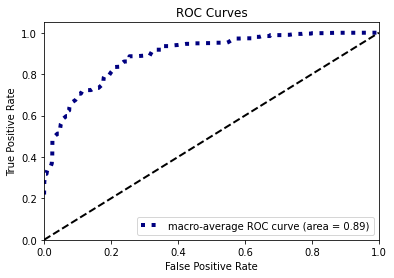

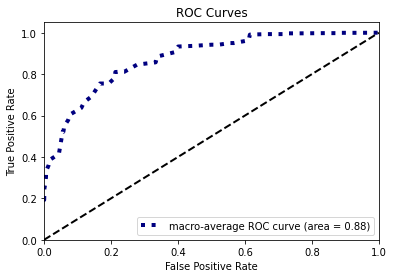

In [41]:
plot_roc_curve(y_true=yt[tgt],y_probas=modelo.predict_proba(Xt[varw]),curves='macro')
plot_roc_curve(y_true=yv[tgt],y_probas=modelo.predict_proba(Xv[varw]),curves='macro')

## Transformación Scoring

In [88]:
PDO = 24
base_score = 745
base_odds = 2
factor = PDO / np.log(2)
offset = base_score-factor*np.log(base_odds)
print(factor,offset)

34.624680981335125 721.0


In [89]:
betas = modelo.coef_[0].tolist()
beta0 = modelo.intercept_[0]

In [90]:
n = len(betas)

In [91]:
for v,beta in zip(varw,betas):
    Xt[f'p_{v}'] = np.ceil((-Xt[v]*beta+beta0/n)*factor+offset/n)
    Xv[f'p_{v}'] = np.ceil((-Xv[v]*beta+beta0/n)*factor+offset/n)

In [92]:
varp = Xt.filter(like='p_').columns.tolist()
varp

['p_w_d_age_4',
 'p_w_d_amt_4',
 'p_w_d_hour_5',
 'p_w_d_lat_5',
 'p_w_d_long_5',
 'p_w_d_merch_lat_5',
 'p_w_d_merch_long_5',
 'p_w_n_gender',
 'p_w_n_state',
 'p_w_n_weekday',
 'p_w_n_month']

In [93]:
Xt['score'] = Xt[varp].sum(axis=1)
Xv['score'] = Xv[varp].sum(axis=1)

<AxesSubplot:xlabel='score', ylabel='Density'>

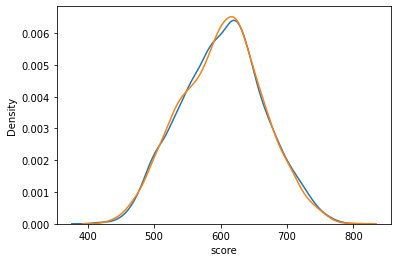

In [94]:
sns.distplot(Xt['score'],hist=False)
sns.distplot(Xv['score'],hist=False)

### Crear scorecard

In [95]:
lsc = []
for vi,vp in zip([v[2:] for v in varw],varp):
    aux = Xt[[vi,vp]].drop_duplicates()
    aux = aux.sort_values(by=vi,ascending=True).reset_index(drop=True)
    aux.columns = ['atributo','puntos']
    aux['caracteristica'] = vi
    lsc.append(aux)

In [96]:
scorecard = pd.concat(lsc,ignore_index=True)

In [97]:
scorecard = scorecard.groupby(['caracteristica','atributo']).sum('puntos')

In [98]:
scorecard.to_excel('scorecard_fraude.xlsx')

In [99]:
df.sample(1)

,ID,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,weekday,month,age,n_merchant,n_category,n_gender,n_city,n_state,n_zip,n_job,n_weekday,n_month,d_amt_2,d_amt_3,d_amt_4,d_amt_5,d_lat_2,d_lat_3,d_lat_4,d_lat_5,d_long_2,d_long_3,d_long_4,d_long_5,d_age_2,d_age_3,d_age_4,d_age_5,d_merch_lat_2,d_merch_lat_3,d_merch_lat_4,d_merch_lat_5,d_merch_long_2,d_merch_long_3,d_merch_long_4,d_merch_long_5,d_hour_2,d_hour_3,d_hour_4,d_hour_5
5826,871444,2019-12-20 16:01:16,4364010865167176,fraud_Barton Inc,grocery_pos,58.57,Gary,Martinez,M,03512 Jackson Ports,Reno,NV,89512,39.5483,-119.7957,276896,Immunologist,1997-03-12,4756a9441a42f47ca946dcc9e166b9f9,1356019276,40.391435,-119.131904,0,16,V,12,22.775738,SMALL CATEGORIES,grocery_pos,M,SMALL CATEGORIES,SMALL CATEGORIES,SMALL CATEGORIES,SMALL CATEGORIES,V,12,"(46.415, 2481.4]","(20.77, 69.36]","(46.415, 81.695]","(30.876, 59.49]","(39.346, 65.69]","(36.666, 41.004]","(39.346, 41.847]","(38.259, 40.468]","(-165.673, -87.725]","(-165.673, -93.87]","(-165.673, -96.791]","(-165.673, -98.737]","(14.06, 44.263]","(14.06, 35.951]","(14.06, 32.815]","(14.06, 30.696]","(39.374, 66.037]","(36.622, 41.027]","(39.374, 41.894]","(40.38, 42.617]","(-166.645, -87.61]","(-166.645, -93.927]","(-166.645, -96.877]","(-166.645, -98.82]","(14.0, 23.0]","(10.0, 17.0]","(14.0, 19.0]","(12.0, 16.0]"


In [100]:
Xt[(Xt['score']>=490)&(Xt['score']<=500)].is_fraud.mean()

0.013071895424836602

In [101]:
Xt.score.describe()

count    7000.000000
mean      603.047714
std        62.449797
min       408.000000
25%       559.000000
50%       605.000000
75%       645.000000
max       784.000000
Name: score, dtype: float64

In [102]:
Xv.score.describe()

count    3000.000000
mean      602.084667
std        61.678302
min       430.000000
25%       558.000000
50%       605.000000
75%       644.000000
max       797.000000
Name: score, dtype: float64

In [126]:
aux = Xt[['score']+um].copy()
aux = aux.merge(yt,on=um,how='inner').assign(tipo='train')

aux['r_score'] = pd.cut(aux['score'],
                        bins=range(400,880,80),
                        include_lowest=True).astype(str)

aux.pivot_table(index=['r_score','tipo'],columns=tgt,values=um,aggfunc='count',fill_value=0).to_clipboard()

In [127]:
aux = Xv[['score']+um].copy()
aux = aux.merge(yv,on=um,how='inner').assign(tipo='valid')

aux['r_score'] = pd.cut(aux['score'],
                        bins=range(400,880,80),
                        include_lowest=True).astype(str)

aux.pivot_table(index=['r_score','tipo'],columns=tgt,values=um,aggfunc='count',fill_value=0).to_clipboard()

In [129]:
df['amt'].mean()

67.10994699999999

In [130]:
df.shape

(10000, 64)

In [131]:
pd.read_csv('/home/jose/Documentos/bd/cc_fraud/fraudTrain.csv').shape

(1296675, 23)

## Reportes de Estabilidad y Desempeño

### Estabilidad de la Población

In [152]:
aux = Xv[['score']+um].merge(df[um+['trans_date_trans_time']],on=um,how='inner')
aux['r_score'] = pd.cut(aux['score'],
                        bins=range(400,880,80),
                        include_lowest=True).astype(str)

In [153]:
aux.head()

,score,ID,trans_date_trans_time,r_score
0,667.0,930115,2020-01-04 15:51:56,"(640.0, 720.0]"
1,622.0,1173391,2020-05-04 20:28:20,"(560.0, 640.0]"
2,609.0,1268160,2020-06-10 19:26:40,"(560.0, 640.0]"
3,529.0,541695,2019-08-19 21:37:29,"(480.0, 560.0]"
4,660.0,970183,2020-01-27 08:17:40,"(640.0, 720.0]"


In [154]:
aux['trans_date_trans_time'].min(),aux['trans_date_trans_time'].max()

(Timestamp('2019-01-01 01:23:50'), Timestamp('2020-06-21 12:01:35'))

In [155]:
aux['mes'] = aux['trans_date_trans_time'].map(lambda x:x.strftime('%Y%m'))

In [156]:
aux[['mes','r_score']+um].groupby(['mes','r_score']).count().to_clipboard()

### Estabilidad de Características

In [176]:
aux = Xv[best+um].merge(df[um+['trans_date_trans_time']],on=um,how='inner')

In [177]:
aux['mes'] = aux['trans_date_trans_time'].map(lambda x:x.strftime('%Y%m'))

In [180]:
l = []
for c in best:
    aux2 = aux[[c,'mes']+um].groupby([c,'mes']).count().reset_index()
    aux2.rename(columns={c:'atributo'},inplace=True)
    aux2.insert(0,'caracteristica',c)
    l.append(aux2)

In [182]:
pd.concat(l,ignore_index=True).to_clipboard()

### Poder predictivo

In [194]:
aux = Xt[['score']+um].merge(df[um+['trans_date_trans_time',tgt]],on=um,how='inner')
aux['r_score'] = pd.cut(aux['score'],
                        bins=range(400,840,40),
                        include_lowest=True).astype(str)
aux['mes'] = aux['trans_date_trans_time'].map(lambda x:x.strftime('%Y%m'))

In [195]:
aux

,score,ID,trans_date_trans_time,is_fraud,r_score,mes
0,560.0,43897,2019-01-27 06:58:24,0,"(520.0, 560.0]",201901
1,649.0,1185149,2020-05-10 12:40:17,0,"(640.0, 680.0]",202005
2,530.0,39567,2019-01-24 02:29:49,0,"(520.0, 560.0]",201901
3,583.0,330434,2019-06-06 16:41:03,0,"(560.0, 600.0]",201906
4,625.0,578850,2019-09-02 07:14:31,0,"(600.0, 640.0]",201909
...,...,...,...,...,...,...
6995,516.0,778698,2019-11-30 01:38:35,0,"(480.0, 520.0]",201911
6996,530.0,1174565,2020-05-05 06:32:58,0,"(520.0, 560.0]",202005
6997,567.0,151345,2019-03-22 21:37:09,0,"(560.0, 600.0]",201903
6998,579.0,245702,2019-05-03 13:13:12,0,"(560.0, 600.0]",201905


In [196]:
aux[['r_score','mes',tgt]+um].groupby(['r_score','mes',tgt]).count().to_clipboard()

### Poder de Características

In [197]:
aux = Xv[best+um].merge(df[um+['trans_date_trans_time',tgt]],on=um,how='inner')

In [198]:
aux['mes'] = aux['trans_date_trans_time'].map(lambda x:x.strftime('%Y%m'))

In [199]:
l = []
for c in best:
    aux2 = aux[[c,'mes',tgt]+um].groupby([c,'mes',tgt]).count().reset_index()
    aux2.rename(columns={c:'atributo'},inplace=True)
    aux2.insert(0,'caracteristica',c)
    l.append(aux2)

In [201]:
pd.concat(l,ignore_index=True).to_clipboard(index=False)